# Tienda en linea


# Contents

* [1.-Introducción y objetivos.](#objetivo)
* [2.-Importacion de los archivos y limpieza ](#importacion)
* [3.-Priorizacion de la hipotesis](#preparación)
* [4.-Analisis del test A/B](#ANALISIS)
* [5.-Conclusion general](#conclusiones)

# 1. Introduccion y objetivos

Para la tienda en linea hemos encontrado junto con el departamento de marketing una lista de hipótesis que pueden ayudar a aumentar los ingresos.
El objetivo de este proyecto es priorizar este listado de hipótesis, lanzar un test A/B y analizar los resultados.

Disponemos de 3 datasets que contienen la siguiente informacion: listado de las hipotesis a evaluar y priorizar, la data de las ordenes de compra de los usuarios como tambien el registro de las visitas al sitio web de la tienda.

# 2. Importacion de los archivos y limpieza

**Primero importaremos las liberias con las que vamos a trabajar para todo el proyecto.**

In [83]:
# Importacion de librerias
import pandas as pd
import matplotlib as plt 
import numpy as np 
import math as mth
import datetime as dt
import scipy.stats as stats


**Subimos los 3 datasets: listado de hipotesis, ordenes y visitas**

In [84]:
#Dataframe hipotesis
hipotesis=pd.read_csv('/datasets/hypotheses_us.csv',sep=';')
hipotesis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Effort      9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


Tenemos 9 hipotesis de las cuales tendremos que priorizar mas adelante y cada una tiene su criterio de alcance,impacto, confidencia y esfuerzo. 

In [85]:
#Dataframe orders
orders=pd.read_csv('/datasets/orders_us.csv', sep=',')
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   transactionId  1197 non-null   int64  
 1   visitorId      1197 non-null   int64  
 2   date           1197 non-null   object 
 3   revenue        1197 non-null   float64
 4   group          1197 non-null   object 
dtypes: float64(1), int64(2), object(2)
memory usage: 46.9+ KB


Tenemos: 1,197 registros de ordenes de compra de los clientes

transactionId: identificador de pedido

visitorId: identificador del usuario que realizó el pedido

date: fecha del pedido

revenue: ingresos del pedido

group: el grupo del test A/B al que pertenece el usuario

In [86]:
# Dataframe visitas
visitas= pd.read_csv('/datasets/visits_us.csv', sep=',')
visitas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    62 non-null     object
 1   group   62 non-null     object
 2   visits  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


Tenemos: 62 registros de visitas al sitio web que contine a los 2 grupos A y B.

date: la fecha

group: grupo del test A/B

visits: el número de visitas en la fecha especificada para el grupo de test A/B especificado

**Pre-procesamiento y limpieza de datos**

1. Limpieza

In [87]:
#Dataframe hipotesis

El dataframe que contiene las hipotesis se encuentran los nombres de las columnas en mayusculas por lo que cambiaremos todas a minusculas.

In [88]:
columns= hipotesis.columns
hipotesis.set_axis(columns.str.lower(), axis='columns', inplace=True)
hipotesis.head(2)

,hypothesis,reach,impact,confidence,effort
0,Add two new channels for attracting traffic. T...,3,10,8,6
1,Launch your own delivery service. This will sh...,2,5,4,10


In [89]:
#Dataframe orders

El dataframe no contiene un separador en el nombre de las columnas, vamos a aplicar la correcion.

In [90]:
orders=orders.rename(columns={'transactionId': 'transaction_id','visitorId':'visitor_id'})
orders.head()

,transaction_id,visitor_id,date,revenue,group
0,3667963787,3312258926,2019-08-15,30.4,B
1,2804400009,3642806036,2019-08-15,15.2,B
2,2961555356,4069496402,2019-08-15,10.2,A
3,3797467345,1196621759,2019-08-15,155.1,B
4,2282983706,2322279887,2019-08-15,40.5,B


2. Evaluacion valores ausentes

In [91]:
hipotesis.isna().sum()

hypothesis    0
reach         0
impact        0
confidence    0
effort        0
dtype: int64

In [92]:
orders.isna().sum()

transaction_id    0
visitor_id        0
date              0
revenue           0
group             0
dtype: int64

In [93]:
visitas.isna().sum()

date      0
group     0
visits    0
dtype: int64

3. Evaluacion valores duplicados

In [94]:
hipotesis.duplicated().sum()

0

In [95]:
orders.duplicated().sum()

0

In [96]:
visitas.duplicated().sum()

0

Podemos ver que los 3 datasets se encuentran en orden sin valores ausentes ni tampoco duplicados. Sin embargo verificaremos que el dataframe de orders se encuentren usuarios unicos en cada grupo para eso realizaremos una tabla dinamica.

<div class="alert alert-block alert-success">
    
<b>Comentario del revisor</b> <a class="tocSkip"></a> Seria mejor si muestras los datos en DataFrame.

In [17]:
#Tabla dinamica 
pivot= orders.pivot_table(index=['visitor_id'],columns='group',values='revenue',aggfunc='count')
pivot    

group,A,B
visitor_id,,
5114589,NaN,1.0
6958315,NaN,1.0
8300375,1.0,1.0
11685486,1.0,NaN
39475350,NaN,1.0
...,...,...
4266935830,1.0,1.0
4278982564,1.0,NaN
4279090005,NaN,1.0


1. Pre_procesamiento

En este caso logramos encontrar que el usuario:8300375 se encuentra tanto en el grupo A como en el B. Por lo tanto no nos sirve para nuestro experimento tener repetido el mismo usuario porque no seria valido los resultados. A continuacion realizaremos un agrupamiento del dataframe y contabilizaremos el numero de veces que aparece.

In [97]:
#Agrupamiento
orders_=orders.groupby(['visitor_id','group','date'])['revenue'].agg('count').reset_index()
orders_.rename(columns={'revenue':'numero_visitas'},inplace=True)

orders_.head()

,visitor_id,group,date,numero_visitas
0,5114589,B,2019-08-16,1
1,6958315,B,2019-08-04,1
2,8300375,A,2019-08-07,1
3,8300375,B,2019-08-01,1
4,11685486,A,2019-08-23,1


In [112]:
#Agrupamos el numero de visitas por usuario y tambien indicaremos la suma de cuantos grupos se encuentra.
df= orders_.pivot_table(index=['visitor_id'],values=['group','numero_visitas','date'],aggfunc={'group':pd.Series.nunique,'numero_visitas':np.sum,'date':','.join}).reset_index()
df.sort_values(by='numero_visitas',ascending=False)                                                                                                                                                                                          
                                                                                                 

,visitor_id,date,group,numero_visitas
1023,4256040402,"2019-08-01,2019-08-12,2019-08-17,2019-08-20,20...",2,11
591,2458001652,"2019-08-04,2019-08-06,2019-08-07,2019-08-11,20...",2,11
569,2378935119,"2019-08-10,2019-08-15,2019-08-17,2019-08-22,20...",2,9
487,2038680547,"2019-08-04,2019-08-17,2019-08-22,2019-08-25,20...",2,8
44,199603092,"2019-08-12,2019-08-15,2019-08-22,2019-08-27,20...",2,5
...,...,...,...,...
359,1484903144,2019-08-14,1,1
360,1485964287,2019-08-26,1,1
361,1494664757,2019-08-15,1,1
362,1495112755,2019-08-12,1,1


In [106]:
# Realizamos un filtro para tener unicamente a los usuarios que se encuentran dentro de los 2 grupos.
df_a_b= df[df['group']>1][['visitor_id','numero_visitas','date']]
df_a_b.head()

,visitor_id,numero_visitas,date
2,8300375,2,"2019-08-07,2019-08-01"
44,199603092,5,"2019-08-12,2019-08-15,2019-08-22,2019-08-27,20..."
51,232979603,2,"2019-08-31,2019-08-31"
55,237748145,5,"2019-08-12,2019-08-15,2019-08-20,2019-08-27,20..."
66,276558944,2,"2019-08-12,2019-08-22"


In [107]:
# Con el atributo de shape podemos ver que son 58 usuarios unicos que se encontran tanto en el grupo A como B.
df_a_b.shape

(58, 3)

In [108]:
# Pasamos una nueva variable para que contega la lista de usuarios que estan repetidos.
delete_a_b=df_a_b['visitor_id'].tolist()

# Eliminamos las filas del dataframe original que contenga a los usuarios dentro de la lista ya identificada.

orders=orders.drop(orders[orders['visitor_id'].isin(delete_a_b)].index)
orders=orders.reset_index(drop=True)

# Mostramos la informacion del nuevo dataframe
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1016 entries, 0 to 1015
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   transaction_id  1016 non-null   int64  
 1   visitor_id      1016 non-null   int64  
 2   date            1016 non-null   object 
 3   revenue         1016 non-null   float64
 4   group           1016 non-null   object 
dtypes: float64(1), int64(2), object(2)
memory usage: 39.8+ KB


In [114]:
# Vemos la distribucion de cuantos usuarios se encuentran en cada grupo.
grupo=orders.groupby(['group'])['revenue'].agg('count')
grupo

group
A    468
B    548
Name: revenue, dtype: int64

Podemos ver que teniamos 58 usuarios unicos que estaban repetidos una/ o varias veces en ambos grupos y al eliminarlos el nuevo dataframe de orders quedo con 1.016 usuarios unicos, distribuidos en 468 en A y 548 en B. De esta manera ya tenemos los dataframes limpios y procesados para el posterior analisis del test A/B.

<div class="alert alert-block alert-success">
    
<b>Comentario del revisor</b> <a class="tocSkip"></a> Todo bien con esa parte!

# 3. Priorizacion de la hipotesis

En esta seccion es importante que a traves de los metodos ICE y RICE podamos aplicar y evaluar cuales son las hipotesis que dan un mayor puntaje que nos indican que son mas relevantes para el negocio poder probarlas.

Mostraremos el dataframe de las hipotesis para leer cada una de ellas y tambien observar su valor en cada parametro.

In [19]:
hipotesis.head(9)

,hypothesis,reach,impact,confidence,effort
0,Add two new channels for attracting traffic. T...,3,10,8,6
1,Launch your own delivery service. This will sh...,2,5,4,10
2,Add product recommendation blocks to the store...,8,3,7,3
3,Change the category structure. This will incre...,8,3,3,8
4,Change the background color on the main page. ...,3,1,1,1
5,Add a customer review page. This will increase...,3,2,2,3
6,Show banners with current offers and sales on ...,5,3,8,3
7,Add a subscription form to all the main pages....,10,7,8,5
8,Launch a promotion that gives users discounts ...,1,9,9,5


**Como primer paso aplicaremos el framework ICE para priorizar hipótesis y las ordenarlas en orden descendente de prioridad.**

In [20]:
hipotesis['ICE']= (hipotesis['impact']* hipotesis['confidence'])/hipotesis['effort']
print(hipotesis[['hypothesis','ICE']].sort_values(by='ICE',ascending=False))

                                          hypothesis        ICE
8  Launch a promotion that gives users discounts ...  16.200000
0  Add two new channels for attracting traffic. T...  13.333333
7  Add a subscription form to all the main pages....  11.200000
6  Show banners with current offers and sales on ...   8.000000
2  Add product recommendation blocks to the store...   7.000000
1  Launch your own delivery service. This will sh...   2.000000
5  Add a customer review page. This will increase...   1.333333
3  Change the category structure. This will incre...   1.125000
4  Change the background color on the main page. ...   1.000000


* Las hipotesis mas prometedoras para aumentar el nivel de ingresos son la 9,1 y 8 con los valores mas altos en el ICE, es decir en el impacto, confianza y esfuerzo.


<div class="alert alert-block alert-success">
    
<b>Comentario del revisor</b> <a class="tocSkip"></a> Aqui correcto!

**Aplicaremos el metodo RICE para identificar cuales hipotesis debemos priorizar y las ordenaremos en forma descendente de acuerdo a su resultado.**

In [21]:
hipotesis['RICE']=(hipotesis['reach']* hipotesis['impact']* hipotesis['confidence']) / hipotesis['effort']
print(hipotesis[['hypothesis','RICE']].sort_values(by='RICE',ascending=False))

                                          hypothesis   RICE
7  Add a subscription form to all the main pages....  112.0
2  Add product recommendation blocks to the store...   56.0
0  Add two new channels for attracting traffic. T...   40.0
6  Show banners with current offers and sales on ...   40.0
8  Launch a promotion that gives users discounts ...   16.2
3  Change the category structure. This will incre...    9.0
1  Launch your own delivery service. This will sh...    4.0
5  Add a customer review page. This will increase...    4.0
4  Change the background color on the main page. ...    3.0


**Conclusiones intermedias**



* Aplicando el metodo RICE, vemos que los puntajes son muchos mas altos porque consideran el factor "Reach" que el metodo ICE no lo contemplaba, ademas  que ese factor permite que el orden de la priorizacion de hipotesis cambie totalmente. 

* Al aplicar el orden descendente, en el metodo RICE cambia siendo la hipotesis 8la que alcanzo el primer lugar, seguido de la hipotesis 3 y 1. 
* Dentro del top 3 de hipotesis con mejores resultados, para ambos metodos sacaron en comun a la numero 8. Aunque para el metodo ICE quedo en 3 lugar, para el metodo RICE fue la que alcanzo el puntaje maximo. De igual manera sucedio con la hipotesis numero 1, con el ICE quedo en 2 lugar y con RICE en 3 lugar.
* Dado que se debe priorizar la hipotesis con el fin de reducir gastos experimentales y que sea la hipotesis de mayor valor prometedor para el negocio en terminos de aumentar los ingresos, escogeremos la hipotesis numero 8: Add a subscription form to all the main pages, por tener los puntajes mas altos en ambos metodos y sobre todo porque en el RICE contemplamos todos los parametros de Alcance, Impacto, Confianza y esfuerzo, de manera que al no inclurlos todos como el metodo ICE afecta el resultado y por ende se subestima su potencial.



<div class="alert alert-block alert-success">
    
<b>Comentario del revisor</b> <a class="tocSkip"></a> Todo bien con los conclusiones!

# 4. Analisis del test A/B

Despues de realizar el experimento, obtenemos los siguientes resultados que analizaremos a continuacion por cada punto.

**1.Representa gráficamente el ingreso acumulado por grupo. Haz conclusiones y conjeturas.**

In [117]:
#Subimos los datos de los pedidos
orders['date'] = orders['date'].map(
    lambda x: dt.datetime.strptime(x, '%Y-%m-%d')
)

#Subimos los datos de las visitas

visitas['date'] = visitas['date'].map(
    lambda x: dt.datetime.strptime(x, '%Y-%m-%d')
)

print(orders.head(5))
print()
print(visitas.head(5))

   transaction_id  visitor_id       date  revenue group
0      3667963787  3312258926 2019-08-15     30.4     B
1      2804400009  3642806036 2019-08-15     15.2     B
2      3797467345  1196621759 2019-08-15    155.1     B
3      2282983706  2322279887 2019-08-15     40.5     B
4       182168103   935554773 2019-08-15     35.0     B

        date group  visits
0 2019-08-01     A     719
1 2019-08-02     A     619
2 2019-08-03     A     507
3 2019-08-04     A     717
4 2019-08-05     A     756


Para trazar los gráficos, tenemos que recopilar datos acumulados. Vamos a declalar un DataFrame llamado cumulativeData con las siguientes columnas:

* date
* group
* orders — el número de pedidos en la fecha especificada para el grupo especificado
* buyers — el número de usuarios que realizan al menos un pedido en la fecha especificada para el grupo especificado
* revenue — los ingresos en la fecha especificada para el grupo especificado (tamaño promedio de compra)
* visitors — el número de visitantes de la tienda en línea en la fecha especificada para el grupo especificado

Vamos a crear una matriz con valores únicos de parejas fecha-grupo 

In [118]:
datesGroups = orders[['date','group']].drop_duplicates() 

In [119]:
#Datos diarios acumulados agregados sobre las ordenes:
ordersAggregated = datesGroups.apply(lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])].agg({'date' : 'max', 'group' : 'max', 'transaction_id' : pd.Series.nunique, 'visitor_id' : pd.Series.nunique, 'revenue' : 'sum'}), axis=1).sort_values(by=['date','group'])

In [120]:
#Datos diarios acumulados agregados sobre las visitas:
visitorsAggregated = datesGroups.apply(lambda x: visitas[np.logical_and(visitas['date'] <= x['date'], visitas['group'] == x['group'])].agg({'date' : 'max', 'group' : 'max', 'visits' : 'sum'}), axis=1).sort_values(by=['date','group'])

Fusionamos las dos tablas en una y damos a sus columnas nombres descriptivos:

In [121]:
# fusionamos las dos tablas en una y da a sus columnas nombres descriptivos
cumulativeData = ordersAggregated.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visits']

print(cumulativeData.head(5))

        date group  orders  buyers  revenue  visits
0 2019-08-01     A      23      19   2266.6     719
1 2019-08-01     B      17      17    967.2     713
2 2019-08-02     A      42      36   3734.9    1338
3 2019-08-02     B      40      39   3535.3    1294
4 2019-08-03     A      66      60   5550.1    1845


Creemos gráficos de ingresos acumulados por día y grupo de prueba A/B:

Text(0.5, 1.0, 'Ingresos acumulados por dia y grupo de prueba A/B')

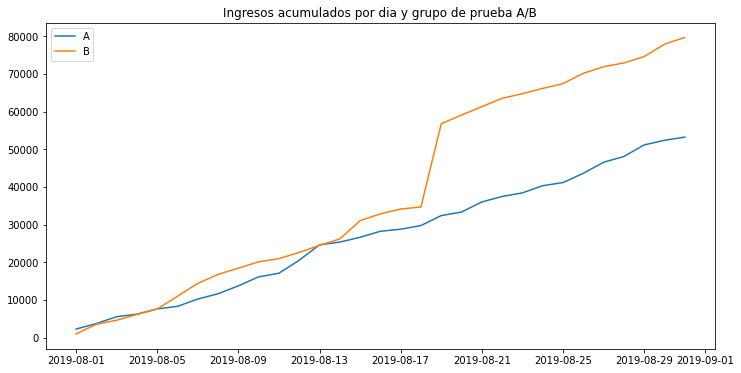

In [127]:
import matplotlib.pyplot as plt

# DataFrame con pedidos acumulados e ingresos acumulados por día, grupo A
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]

# DataFrame con pedidos acumulados e ingresos acumulados por día, grupo B
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]

# Trazar el gráfico de ingresos del grupo A
plt.figure(figsize=(12,6))
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')

# Trazar el gráfico de ingresos del grupo B
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')

plt.legend()

plt.title('Ingresos acumulados por dia y grupo de prueba A/B')

* Los ingresos acumulados son mayores para el grupo B, especialmente su diferencia con respecto al grupo A aumenta entre las fechas del 17 de agosto del 2019 hasta el 21 de agosto. 

* Los ingresos aumentan constantemente durante toda la prueba. En el grupo A este crecimiento es lineal, solo alcazno un pico el 13 de agosto. En el grupo B si se observa un comportamiento diferente con picos en los ingresos y eso de puede deber al numero de pedidos o por el valor de los pedidos. 

<div class="alert alert-block alert-success">
    
<b>Comentario del revisor</b> <a class="tocSkip"></a> Me gusta mucho el grafico! Aqui esta bien!

**2. Representa gráficamente el tamaño de pedido promedio acumulado por grupo. Haz conclusiones y conjeturas**

Vamos a trazar el tamaño promedio de compra por grupo. Vamos a dividir los ingresos acumulados entre el número acumulado de pedidos:

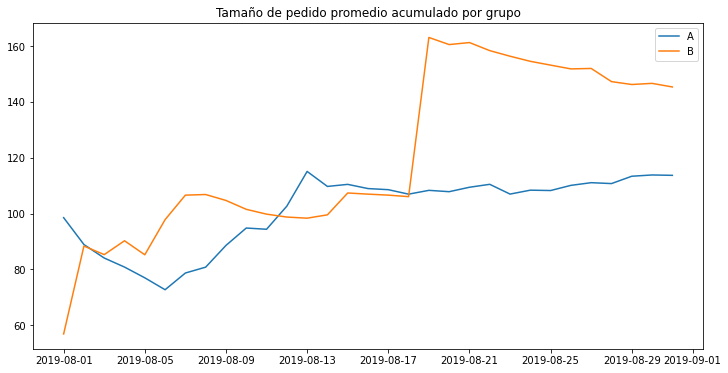

In [125]:
plt.figure(figsize=(12,6))
plt.title('Tamaño de pedido promedio acumulado por grupo')
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')
plt.legend()



* Encontramos que en el grupo B el pico en el nivel de ingresos el 17 de agosto se debio por el gran aumento en el numero promedio de pedidos, pasando de 115 a 160 y desde esa fecha en adelante se mantiene hasta 150 ordenes.

* Para el grupo a vemos que el tamaño de compra promedio es variante a lo largo del periodo, sin embargo alcanza un pico el 13 de agosto con 120 ordenes, y despues se estabiliza y se mantiene levemente constante en un nivel del 115 ordenes. 

* Lo que encontramos en comun para ambos grupos es que en los primeros dias del mes sus nivele de promedio eran bajos pero al transcurrir los dias va aumentando hasta fin de mes.


**3.Representa gráficamente la diferencia relativa en el tamaño de pedido promedio acumulado para el grupo B en comparación con el grupo A. Haz conclusiones y conjeturas.**


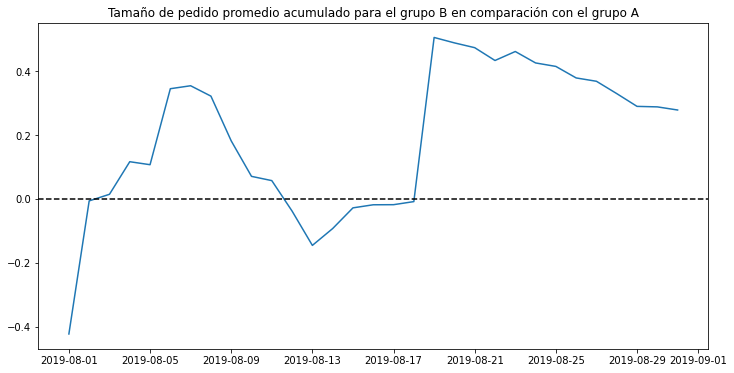

In [124]:
# Reuninimos los datos en un DataFrame
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

# Trazamos un gráfico de diferencia relativa para los tamaños de compra promedio

plt.figure(figsize=(12,6))
plt.title('Tamaño de pedido promedio acumulado para el grupo B en comparación con el grupo A')
plt.plot(mergedCumulativeRevenue['date'], (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)

# Agregamos el eje X
plt.axhline(y=0, color='black', linestyle='--')

* En varios puntos, la diferencia entre los segmentos aumenta. Esto significa que deben haber algunos pedidos grandes y valores atípicos.

<div class="alert alert-block alert-success">
    
<b>Comentario del revisor</b> <a class="tocSkip"></a> Podemos hacer mas conclusiones?

**4.Calcula la tasa de conversión de cada grupo como la relación entre los pedidos y el número de visitas de cada día. Representa gráficamente las tasas de conversión diarias de los dos grupos y describe la diferencia. Saca conclusiones y haz conjeturas.**

Text(0.5, 1.0, 'Grafico: tasas de conversion diarias del grupo A y B')

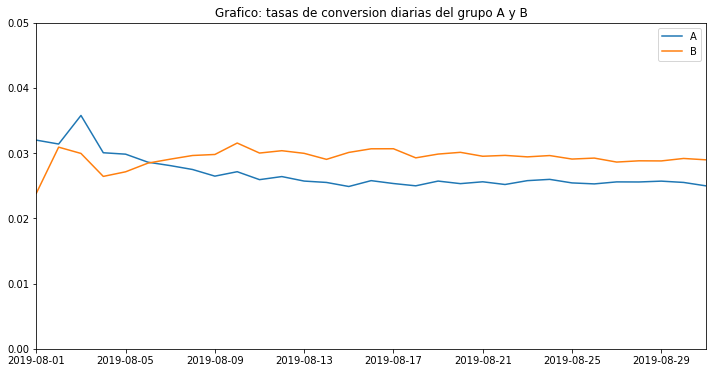

In [130]:
# Calculamos la conversión acumulada
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visits']

# Seleccionamos datos en el grupo A
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']

# Seleccionamos datos en el grupo B
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

# Trazamos los gráficos
plt.figure(figsize=(12,6))

plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')
plt.legend()

#Establecemos la escala de los ejes
plt.axis([pd.to_datetime("2019-08-01"), pd.to_datetime('2019-08-31'), 0, 0.05])

plt.title('Grafico: tasas de conversion diarias del grupo A y B')

* Los grupos fluctuaron alrededor del mismo valor pero luego la tasa de conversión del grupo B aumentó antes de estabilizarse mientras que la tasa de conversión del grupo A disminuyó pero luego también se estabilizó.


**Vamos a trazar un gráfico de diferencia relativa para las tasas de conversión acumuladas:**

No handles with labels found to put in legend.


Text(0.5, 1.0, 'Diferencia relativa para las tasas de conversion acumuladas')

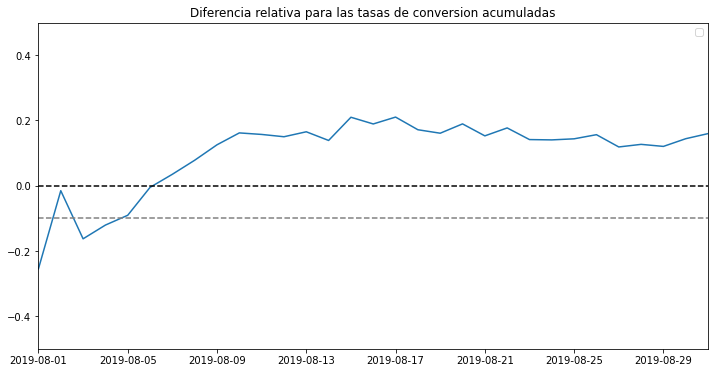

In [132]:
mergedCumulativeConversions = cumulativeDataA[['date','conversion']].merge(cumulativeDataB[['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

plt.figure(figsize=(12,6))
plt.plot(mergedCumulativeConversions['date'], mergedCumulativeConversions['conversionB']/mergedCumulativeConversions['conversionA']-1)
plt.legend()

plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=-0.1, color='grey', linestyle='--')
plt.axis([pd.to_datetime("2019-08-01"), pd.to_datetime('2019-08-31'), -0.5, 0.5])

plt.title('Diferencia relativa para las tasas de conversion acumuladas')

* Podemos ver que tanto en el gráfico de las tasas de conversión diarias de los dos grupos
como el gráfico de la diferencia relativa para las tasas de conversión acumuladas, el grupo
B muestra un mejores resultados que el grupo A.

<div class="alert alert-block alert-success">
    
<b>Comentario del revisor</b> <a class="tocSkip"></a> Todo bien con esa parte!

**5. Traza un gráfico de dispersión del número de pedidos por usuario. Haz conclusiones y conjeturas.**

Vamos a buscar el número de pedidos por usuario e imprimir el resultado:

In [134]:
ordersByUsers = (
    orders.drop(['group', 'revenue', 'date'], axis=1)
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)

ordersByUsers.columns = ['visitor_id', 'orders']

print(ordersByUsers.sort_values(by='orders', ascending=False).head(10))


     visitor_id  orders
908  3967698036       3
55    249864742       3
478  2108163459       3
687  2988190573       3
890  3908431265       3
138   611059232       3
632  2742574263       3
157   678354126       2
323  1404560065       2
452  1985475298       2


* Hay usuarios con 3 y 2 pedidos. Eso es mucho más de lo que un usuario habitual haría en una semana.

Vamos a trazar un histograma de distribución con el número de pedidos por usuario.

Text(0.5, 1.0, 'Distribucion con el numero de pedidos por usuario')

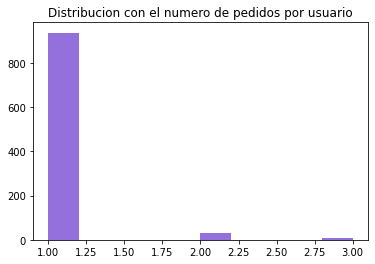

In [164]:
import matplotlib.pyplot as plt 

plt.hist(ordersByUsers['orders'],color='mediumpurple')
plt.title('Distribucion con el numero de pedidos por usuario')

* La mayoría de los clientes hicieron un solo pedido. Sin embargo, tambien hay de dos a tres pedidos cada uno.
Vamos a trazar un gráfico de dispersión con el número de pedidos por usuario:

Text(0.5, 1.0, 'Numero de pedidos por usuario')

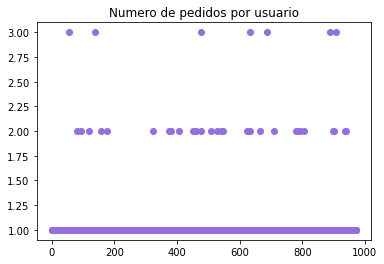

In [165]:
x_values = pd.Series(range(0,len(ordersByUsers)))

plt.scatter(x_values, ordersByUsers['orders'],color='mediumpurple')

plt.title('Numero de pedidos por usuario')

* Nuestras conclusiones se han confirmado: de hecho, hay muchos usuarios con dos o tres pedidos. Se desconoce la proporción exacta, ya que no está claro si debemos considerarlos anomalías o no.

<div class="alert alert-block alert-success">
    
<b>Comentario del revisor</b> <a class="tocSkip"></a> Genial!

**6. Calcula los percentiles 95 y 99 para el número de pedidos por usuario. Define el punto en el cual un punto de datos se convierte en una anomalía.**

Vamos a calcular los percentiles para el número de pedidos por usuario:

In [139]:
print(np.percentile(ordersByUsers['orders'], [ 95, 99]))

[1. 2.]


* No más del 5% de los usuarios realizaron más de 1 pedidos y el 1% de los usuarios realizaron más de dos.

* Por lo tanto, sería razonable establecer un pedido por usuario como límite inferior para el número de pedidos y filtrar las anomalías en base a ello.

**7.Traza un gráfico de dispersión de los precios de los pedidos. Haz conclusiones y conjeturas.**

Text(0.5, 1.0, 'Grafico de dispersion de los precios en los pedidos')

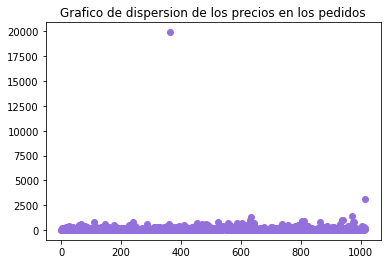

In [166]:
x_values = pd.Series(range(0,len(orders['revenue'])))

plt.scatter(x_values, orders['revenue'],color='mediumpurple')

plt.title('Grafico de dispersion de los precios en los pedidos')

* Podemos ver que la gran mayoría de los pedidos no llegan a los 1.000. Solo uno pasa los 2.500 y otro llega casi a los 20.000. Veamos los percentiles para determinar la proporción

<div class="alert alert-block alert-success">
    
<b>Comentario del revisor</b> <a class="tocSkip"></a> Los valores atípicos también son visibles en el gráfico

**8.Calcula los percentiles 95 y 99 de los precios de los pedidos. Define el punto en el cual un punto de datos se convierte en una anomalía.**


In [142]:
print(np.percentile(orders['revenue'], [ 95, 99]))

[414.275 830.3  ]


* No más del 5% de los usuarios realizaron más de 414 pedidos y el 1% de los usuarios realizaron más de 830.

* Por lo tanto, sería razonable establecer 414 pedidos por usuario como límite inferior para el número de pedidos y filtrar las anomalías en base a ello.

**9.Encuentra la significancia estadística de la diferencia en la conversión entre los grupos utilizando los datos en bruto. Haz conclusiones y conjeturas.**


Vamos a imprimir la ganancia relativa de conversión para el grupo B: conversión del grupo B / conversión del grupo A - 1.

In [146]:
ordersByUsersA = orders[orders['group']=='A'].groupby('visitor_id', as_index=False).agg({'transaction_id' : pd.Series.nunique})
ordersByUsersA.columns = ['visitor_id', 'orders']

ordersByUsersB = orders[orders['group']=='B'].groupby('visitor_id', as_index=False).agg({'transaction_id' : pd.Series.nunique})
ordersByUsersB.columns = ['visitor_id', 'orders']

sampleA = pd.concat([ordersByUsersA['orders'],pd.Series(0, index=np.arange(visitas[visitas['group']=='A']['visits'].sum() - len(ordersByUsersA['orders'])), name='orders')],axis=0)

sampleB = pd.concat([ordersByUsersB['orders'],pd.Series(0, index=np.arange(visitas[visitas['group']=='B']['visits'].sum() - len(ordersByUsersB['orders'])), name='orders')],axis=0)

print("{0:.3f}".format(stats.mannwhitneyu(sampleA, sampleB)[1]))

print("{0:.3f}".format(sampleB.mean()/sampleA.mean()-1))

0.011
0.160


* Según los datos sin procesar, no hay diferencia entre los grupos A y B.
* La primera fila de la salida nos da el valor p — 0,011, que es menor que 0,05. Entonces, rechazamos la hipótesis nula ya que si hay una diferencia estadísticamente significativa en la conversión entre los grupos. Pero la pérdida relativa del grupo B es del 16% (la segunda fila de la salida).

**10.Encuentra la significancia estadística de la diferencia en el tamaño promedio de pedido entre los grupos utilizando los datos en bruto. Haz conclusiones y conjeturas.**

Para calcular la importancia estadística de la diferencia en el tamaño medio de los pedidos de los segmentos, pasaremos los datos sobre los ingresos al criterio mannwhitneyu().
También encontraremos la diferencia relativa en el tamaño promedio de pedido entre los grupos:

In [147]:
print('{0:.3f}'.format(stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1]))
print('{0:.3f}'.format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1))

0.862
0.278


* El valor p es notablemente superior a 0,05 por lo que no hay motivo para rechazar la
hipótesis nula y concluir que el tamaño medio de los pedidos difiere entre los
grupos.
* El tamaño de pedido promedio para el grupo B es un 27.8% más grande que para el
grupo A.

<div class="alert alert-block alert-success">
    
<b>Comentario del revisor</b> <a class="tocSkip"></a> Mui bien!

**11.Encuentra la significancia estadística de la diferencia en la conversión entre los grupos utilizando los datos filtrados. Haz conclusiones y conjeturas.**

Se va a definir los usuarios anómalos como aquellos que realizan más de 1 pedido o un pedido mayor a 414. Así eliminaremos el 5% de los usuarios con mayor número de pedidos y el 5% de los usuarios con los pedidos más caros. 

Crearemos slices de datos con los usuarios que realizaron más de 1 pedido (usersWithManyOrders) y los usuarios que realizaron pedidos por más de 414
(usersWithExpensiveOrders). Los uniremos en una tabla llamada abnormalUsers.


Vamos a encontrar el número total de usuarios anómalos con el método shape().

In [151]:
usersWithManyOrders = pd.concat([ordersByUsersA[ordersByUsersA['orders'] > 1]['visitor_id'], ordersByUsersB[ordersByUsersB['orders'] > 1]['visitor_id']], axis = 0)
usersWithExpensiveOrders = orders[orders['revenue'] > 414]['visitor_id']
abnormalUsers = pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis = 0).drop_duplicates().sort_values()
print(abnormalUsers.head(5))
print(abnormalUsers.shape)

487    113298937
937    148427295
792    204675465
33     249864742
586    358944393
Name: visitor_id, dtype: int64
(86,)


En total, tenemos 86 usuarios anómalos.
Tratemos de averiguar cómo sus acciones afectaron los resultados de la prueba. Calcularemos la significancia estadística de las diferencias en la conversión entre los grupos con datos filtrados. Primero prepararemos muestras del número de pedidos por usuario para cada grupo de prueba.

In [154]:
sampleAFiltered = pd.concat([ordersByUsersA[np.logical_not(ordersByUsersA['visitor_id'].isin(abnormalUsers))]['orders'],pd.Series(0, index=np.arange(visitas[visitas['group']=='A']['visits'].sum() - len(ordersByUsersA['orders'])),name='orders')],axis=0)
sampleBFiltered = pd.concat([ordersByUsersB[np.logical_not(ordersByUsersB['visitor_id'].isin(abnormalUsers))]['orders'],pd.Series(0, index=np.arange(visitas[visitas['group']=='B']['visits'].sum() - len(ordersByUsersB['orders'])),name='orders')],axis=0)


In [155]:
print("{0:.3f}".format(stats.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]))
print("{0:.3f}".format(sampleBFiltered.mean()/sampleAFiltered.mean()-1))

0.016
0.174


* En los resultados sin filtrar, tuvimos un valor p de 0.011 y una ganancia relativa en
la conversión del grupo B sobre el A de 0.16

* En el anáisis de los datos filtrados, también hay diferencia entre los grupos A y B.

* La primera fila de la salida nos da el valor p — 0,016, que es menor que 0,05. Entonces, rechazamos la hipótesis nula ya que hay una diferencia estadísticamente significativa en la conversión entre los grupos.

* La ganancia relativa del grupo B en los datos filtrados es ligeramente mayor que con
los datos en bruto, subiendo al 17,4% (la segunda fila de la salida).

**12.Encuentra la significancia estadística de la diferencia en el tamaño promedio de pedido entre los grupos utilizando los datos filtrados. Haz conclusiones y conjeturas.**

In [159]:
print('{0:.3f}'.format(stats.mannwhitneyu(
    orders[np.logical_and(
        orders['group']=='A',
        np.logical_not(orders['visitor_id'].isin(abnormalUsers)))]['revenue'],
    orders[np.logical_and(
        orders['group']=='B',
        np.logical_not(orders['visitor_id'].isin(abnormalUsers)))]['revenue'])[1]))

print('{0:.3f}'.format(
    orders[np.logical_and(orders['group']=='B',np.logical_not(orders['visitor_id'].isin(abnormalUsers)))]['revenue'].mean()/
    orders[np.logical_and(
        orders['group']=='A',
        np.logical_not(orders['visitor_id'].isin(abnormalUsers)))]['revenue'].mean() - 1))

0.771
-0.033


<div class="alert alert-block alert-success">
    
<b>Comentario del revisor</b> <a class="tocSkip"></a> Funciona correcot! Tambien podias crear funcion asi

* En los resultados sin filtrar, tuvimos un valor p de 0.862 y un tamaño promedio de
compra del grupo B un 0.278 mayor al del grupo A.
* Con los datos filtrados, el valor p también es muy superior a 0,05 por lo que
tampoco tenemos motivo para rechazar la hipótesis nula y concluir que el tamaño
medio de los pedidos difiere entre los grupos.
* Si tenemos en los datos filtrados una diferencia sustancial respecto al tamaño de
pedido promedio para el grupo B respecto al grupo A, ya que en los datos sin filtrar
fue 27% más grande que el del grupo A, y con lo datos filtrados paso a ser 0.03% más
pequeño. Eso quiere decir que si había valores atípicos que afectaron el resultado
con los datos en bruto.

# 5. Conclusiones generales

**13.Toma una decisión basada en los resultados de la prueba.**

Las decisiones posibles son: 

Para la prueba, considera a uno de los grupos como líder. 

Para la prueba, concluye que no hay diferencia entre los grupos. 

Continúa la prueba.

1. El gráfico que muestra la diferencia de conversión entre los grupos
(mergedCumulativeConversions) nos dice que los resultados del grupo B son
mejores que los del grupo A.

2. Ni los datos sin procesar ni los filtrados revelaron diferencias estadísticamente
significativas en el tamaño promedio de los pedidos entre los grupos. Sin embargo,
en los datos sin filtrar, el tamaño promedio del pedido para el grupo B es 27% mayor
al del grupo A. Con los datos filtrados, el tamaño promedio del pedido en el grupo B
es 0.03% menor al del grupo A

3. Los datos sin procesar y los filtrados revelaron diferencias estadísticamente significativas en la conversión entre los grupos, siendo mayor la del grupo B en un 16%

4. Es importante considerar que despues de haber eliminado los usuarios duplicados en cada grupo, la cantidad de usuarios en el grupo B fue mayor que el A, lo que puede haber influido en que su desepeño de conversión haya sido mejor, aumentando la probabilidad de conversion.

5. Dado este caso, podemos llegar a la conclusion que no hay una diferencia entre
los grupos, ya que si bien el grupo B tiene una conversión más alta que la del grupo A, el 
tamaño de ambos grupos no es el mismo, siendo B más grande que A, lo que puede afectar
directamente la conversión.

6. Como lo que se busca es un aumento en los ingresos, se debe repetir la prueba con una
muestra mayor de usuarios y cuidando que el tamaño de ambos grupos sea idéntico.

<div class="alert alert-block alert-success">
Comentarios generales 1
    
<b>Comentario del revisor</b> <a class="tocSkip"></a>
    
    
¡Gran trabajo! Estás muy cerca de culminar con el curso de Científico de Datos pero ya demuestras un conocimiento avanzado de programación, modelamiento y manipulación de datos. El proyecto esta aceptado :)
</div>